In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

kaggle/input/._DLProj1
kaggle/input/DLProj1/cifar_test_nolabel.pkl
kaggle/input/DLProj1/._cifar_test_nolabel.pkl
kaggle/input/DLProj1/._cifar-10-python
kaggle/input/DLProj1/cifar-10-python/._cifar-10-batches-py
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/data_batch_1
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/._data_batch_1
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/readme.html
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/._readme.html
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/batches.meta
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/._batches.meta
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/data_batch_2
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/._data_batch_2
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/data_batch_5
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/._data_batch_5
kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py/test_batch
kaggle/input/

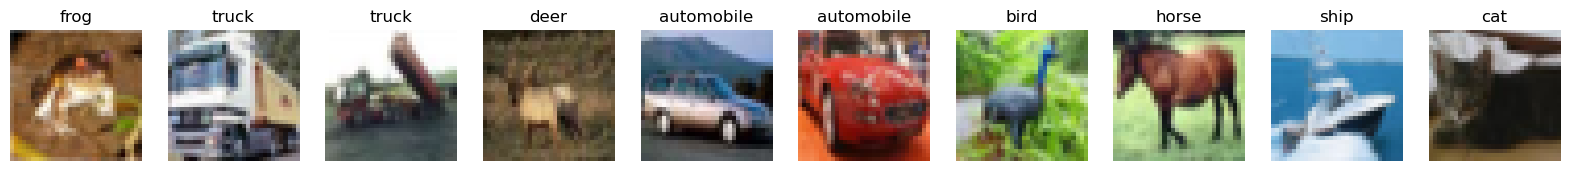

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = 'kaggle/input/DLProj1/cifar-10-python/cifar-10-batches-py'
# cifar10_dir='/DLProj1/cifar-10-python/cifar-10-batches-py/'
# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load one batch for demonstration (e.g., data_batch_1)
batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch_1_dict[b'data']
train_labels = batch_1_dict[b'labels']

# Reshape the images
train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [3]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('kaggle/input/DLProj1/cifar_test_nolabel.pkl')

# Extract images 
images = cifar10_batch[b'data']
# Unlike the train images you are not required to reshape to (number of images, width, height, channels) 
# as the test data is already in (N x W x H x C) format

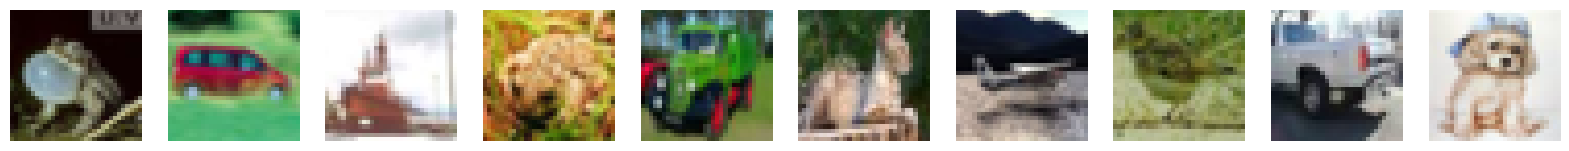

In [4]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

tensor([1.], device='mps:0')
Using mps device


In [6]:
print(type(train_images))
print(train_images.shape)

<class 'numpy.ndarray'>
(10000, 32, 32, 3)


In [8]:
train_data = []
train_labels = []

for i in range(1, 6):  # CIFAR-10 has 5 training batches
    batch_dict = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch_dict[b'data'])
    train_labels.extend(batch_dict[b'labels'])

# Convert training data into NumPy arrays and ensure correct shape
train_images = np.vstack(train_data).reshape(-1, 3, 32, 32).astype(np.float32) / 255.0  # Normalize
train_labels = np.array(train_labels, dtype=np.int64)

# Load test data
test_batch = load_cifar_batch('kaggle/input/DLProj1/cifar_test_nolabel.pkl')
test_images = test_batch[b'data'].transpose(0, 3, 1, 2).astype(np.float32) / 255.0  # Normalize and transpose

# Define Normalization Transform (Only for Tensors)
normalize_transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# Custom Dataset Class
class CIFARDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy to Tensor
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)  # Apply normalization

        if self.labels is not None:
            return image, self.labels[idx]
        else:
            return image

# Create Datasets
train_dataset = CIFARDataset(train_images, train_labels, transform=normalize_transform)
test_dataset = CIFARDataset(test_images, labels=None, transform=normalize_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check if DataLoader is Working
for images, labels in train_loader:
    print(f"Batch size: {images.shape}, Labels: {labels.shape}")
    break  # Only check one batch

Batch size: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


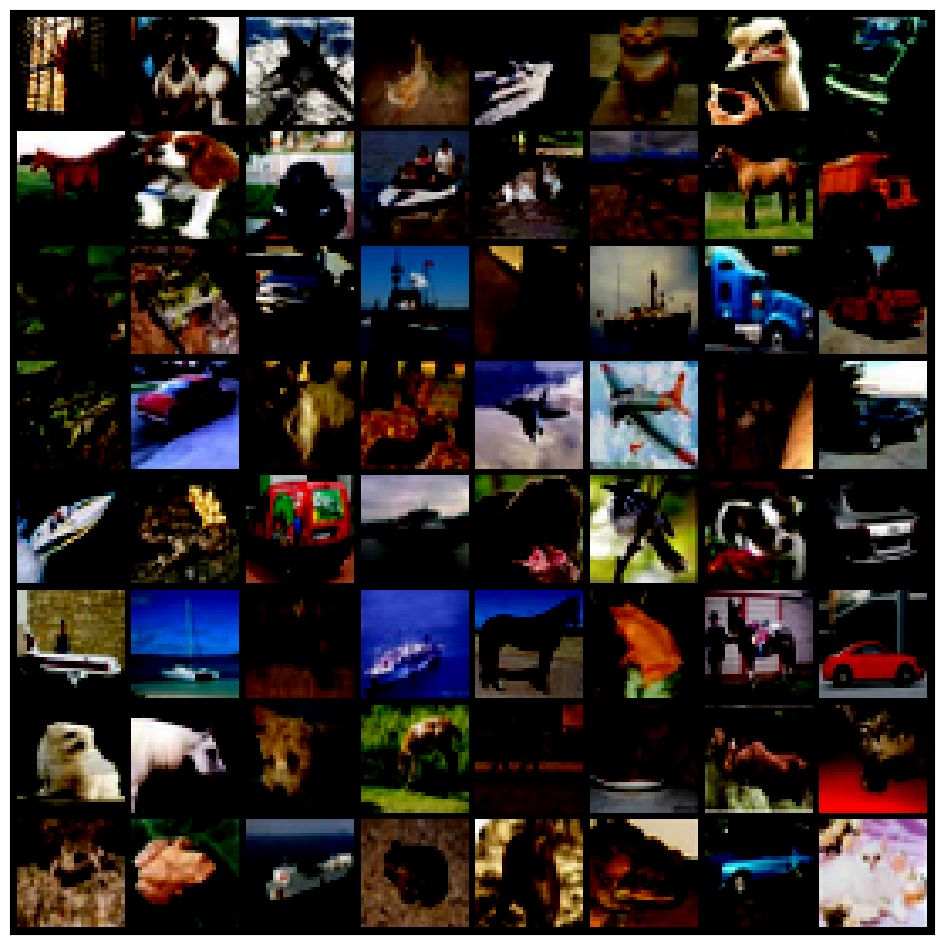

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_loader)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (if input and output channels differ, use 1x1 conv)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Residual connection
        return F.relu(out)

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.layer1 = self._make_layer(32, 32, 2, stride=1)  # 2 ResBlocks
        self.layer2 = self._make_layer(32, 64, 2, stride=2)  # 2 ResBlocks
        self.layer3 = self._make_layer(64, 128, 2, stride=2)  # 2 ResBlocks

        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))  # First block with stride
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))  # Keep stride=1 for remaining blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.gap(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Check model parameter count
model = SimpleResNet()
print(f"Total Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total Trainable Parameters: 696,618


In [17]:
model = SimpleResNet().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # Train for 10 epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 1.2533
Epoch [2/10], Loss: 0.8313
Epoch [3/10], Loss: 0.6429
Epoch [4/10], Loss: 0.5367
Epoch [5/10], Loss: 0.4538
Epoch [6/10], Loss: 0.3908
Epoch [7/10], Loss: 0.3219
Epoch [8/10], Loss: 0.2681
Epoch [9/10], Loss: 0.2230
Epoch [10/10], Loss: 0.1826


Epoch [1/10] → Loss: 1.2379, Train Acc: 55.21%, Test Acc: N/A
Epoch [2/10] → Loss: 0.8242, Train Acc: 70.94%, Test Acc: N/A
Epoch [3/10] → Loss: 0.6446, Train Acc: 77.58%, Test Acc: N/A
Epoch [4/10] → Loss: 0.5320, Train Acc: 81.45%, Test Acc: N/A
Epoch [5/10] → Loss: 0.4468, Train Acc: 84.52%, Test Acc: N/A
Epoch [6/10] → Loss: 0.3784, Train Acc: 86.81%, Test Acc: N/A
Epoch [7/10] → Loss: 0.3189, Train Acc: 88.95%, Test Acc: N/A
Epoch [8/10] → Loss: 0.2633, Train Acc: 90.90%, Test Acc: N/A
Epoch [9/10] → Loss: 0.2143, Train Acc: 92.55%, Test Acc: N/A
Epoch [10/10] → Loss: 0.1782, Train Acc: 93.76%, Test Acc: N/A


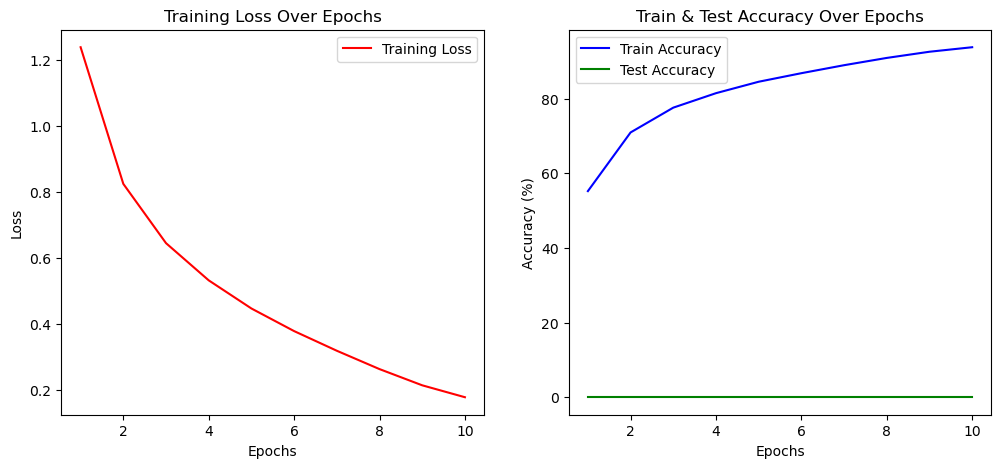

In [35]:
model = SimpleResNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
test_accuracies = []

# Training function
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        test_acc = evaluate(model, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc if test_acc is not None else 0)  # Store 0 if test_acc is None

        # Handle None case in print statement
        test_acc_str = f"{test_acc:.2f}%" if test_acc is not None else "N/A"
        print(f"Epoch [{epoch+1}/{num_epochs}] → Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc_str}")


# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            # If dataset has labels (train), unpack them
            if isinstance(batch, tuple) and len(batch) == 2:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
            else:
                images = batch.to(device)  # Only images (test set)
                labels = None

            outputs = model(images)
            if labels is not None:  # Only calculate accuracy if labels exist
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

    return 100 * correct / total if total > 0 else None  # Return accuracy if labels exist

# Train and evaluate the model
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

# Plot Training Loss, Train Accuracy, and Test Accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label="Training Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies, label="Train Accuracy", color="blue")
plt.plot(range(1, 11), test_accuracies, label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train & Test Accuracy Over Epochs")
plt.legend()

plt.show()


In [30]:
import torch
from torchsummary import summary

modelCpu = SimpleResNet().to("cpu")  # Move model to the correct device

# Call summary with the correct device
summary(modelCpu, input_size=(3, 32, 32), device="cpu")  # Pass device as string


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

In [41]:
import torch
import pandas as pd

# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Ensure model is on the correct device
model.to(device)
model.eval()

# Store predictions
predictions = []

# Disable gradient computation for inference
with torch.no_grad():
    for images in test_loader:  
        images = images.to(device)  # Move images to same device as model
        outputs = model(images)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        predictions.extend(predicted.cpu().numpy())  # Convert tensor to list

# Create a DataFrame for submission
submission_df = pd.DataFrame({'ID': list(range(0, len(predictions))), 'Labels': predictions})

# Save to CSV file
submission_df.to_csv('submission.csv', index=False)

print("✅ Submission file saved as 'submission.csv'")


✅ Submission file saved as 'submission.csv'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7019608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5372549..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..1.0].
Clipping in

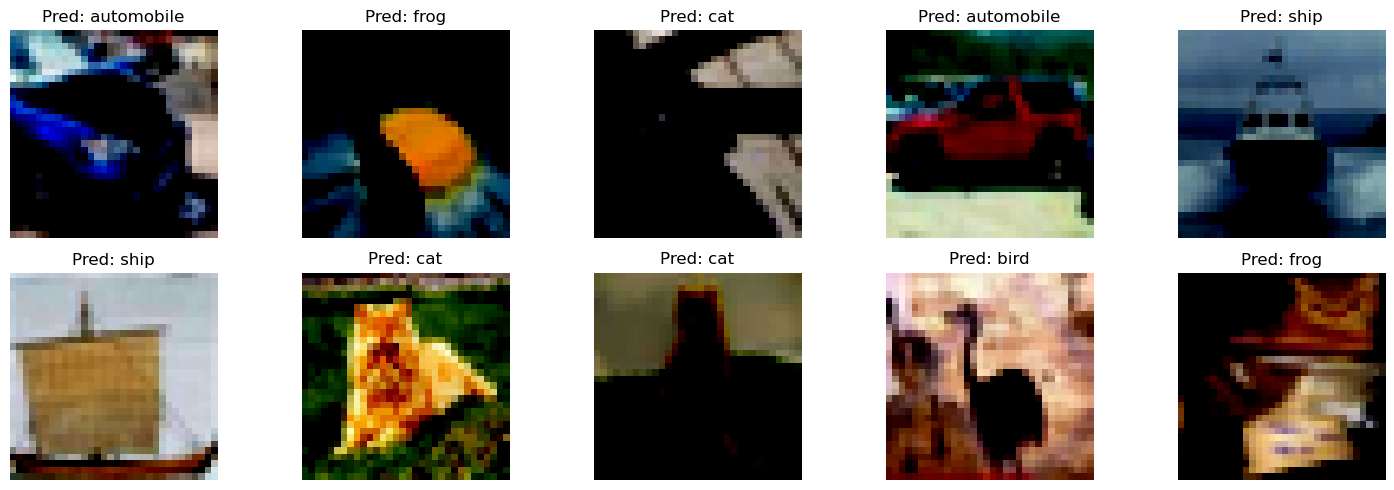

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# CIFAR-10 class labels
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck']

# Set model to evaluation mode
model.eval()

# Select 10 random images from test dataset
random_indices = np.random.randint(0, len(test_dataset), size=10)
random_images = torch.stack([test_dataset[i] for i in random_indices]).to(device)  # Move images to device

# Get predictions
with torch.no_grad():
    outputs = model(random_images)  
    _, predicted_classes = torch.max(outputs, 1)  # Get predicted class indices

# Convert predictions to class names
predicted_labels = [cifar10_labels[i] for i in predicted_classes.cpu().numpy()]

# Plot the images with their predicted labels
plt.figure(figsize=(15, 5))
for i, img_index in enumerate(random_indices):
    img = test_dataset[img_index]  # Get image
    img = img.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {predicted_labels[i]}", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()
